This notebook compares three different data configurations based on the TDT sentiment data set:


1. Focus sentence only
2. Left context + focus sentence
3. Left context + focus sentence + right context

In each case, TFBertForSequenceClassification from Huggingface Transformers is used as the model. With the non-contextual data, uncased FinBERT is used, while the contextual data configurations use cased FinBERT.

In [1]:
# Set the file paths here
tdt_train_fn = '/content/tdt-sentiment-151020-train-clean.tsv'
tdt_eval_fn = '/content/tdt-sentiment-151020-dev.tsv'
tdt_unannotated_full_train_fn = '/content/tdt-train-texts.tsv'
tdt_unannotated_full_eval_fn = '/content/tdt-dev-texts.tsv'

In [ ]:
!pip install transformers

In [4]:
# Choose model and set up input

from transformers import BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
from itertools import groupby
import tensorflow as tf

def transpose(l):
  return [list(t) for t in zip(*l)]

def load_fields(fn):
  return transpose([l.rstrip('\n').split('\t') for l in open(fn).readlines()])

train_id, train_texts, train_labels_raw = load_fields(tdt_train_fn)[:3]
eval_id, eval_texts, eval_labels_raw = load_fields(tdt_eval_fn)[:3]

group_train_id, group_train_texts = load_fields(tdt_unannotated_full_train_fn)[:2]
group_eval_id, group_eval_texts = load_fields(tdt_unannotated_full_eval_fn)[:2]

label_encoder = LabelEncoder()
label_encoder.fit(train_labels_raw)
train_labels = label_encoder.transform(train_labels_raw).tolist()
eval_labels = label_encoder.transform(eval_labels_raw).tolist()
num_labels = len(label_encoder.classes_)

model_name_nc = "TurkuNLP/bert-base-finnish-uncased-v1"
model_name_c = "TurkuNLP/bert-base-finnish-cased-v1"

tokenizer_nc = BertTokenizerFast.from_pretrained(model_name_nc)
tokenizer_c = BertTokenizerFast.from_pretrained(model_name_c)

input_size_nc = 128
input_size_c = 256

train_encodings_nc = tokenizer_nc(train_texts, truncation=True, padding='longest', max_length=input_size_nc)
eval_encodings_nc = tokenizer_nc(eval_texts, truncation=True, padding='longest', max_length=input_size_nc)
train_encodings_c = list(zip([s.split('.', 1)[0] for s in group_train_id], tokenizer_c(group_train_texts, add_special_tokens=False)['input_ids']))
eval_encodings_c = list(zip([s.split('.', 1)[0] for s in group_eval_id], tokenizer_c(group_eval_texts, add_special_tokens=False)['input_ids']))

t = [tf.constant(train_encodings_nc.data['input_ids']),
     tf.constant(train_encodings_nc.data['attention_mask']),
     tf.constant(train_encodings_nc.data['token_type_ids'])]

e = [tf.constant(eval_encodings_nc.data['input_ids']),
     tf.constant(eval_encodings_nc.data['attention_mask']),
     tf.constant(eval_encodings_nc.data['token_type_ids'])]

In [8]:
# Set up data with sentence id separating context from focus sentence

def add_left_sep_context(ids, labels, encodings, input_size, tokenizer):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    prev_context = [e for l in group[:i] for e in l]
    sentence_size = min(len(group[i]), input_size - 3)
    context_size = max(input_size - sentence_size - 3, 0)
    prev_context = prev_context[len(prev_context)-context_size:]
    input = [tokenizer.cls_token_id] + prev_context + [tokenizer.sep_token_id] + group[i][:sentence_size] + [tokenizer.sep_token_id]
    mask = [0] + [0]*len(prev_context) + [0] + [1]*sentence_size + [1]
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

def add_full_sep_context(ids, labels, encodings, input_size, tokenizer):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    prev_context = [e for l in group[:i] for e in l]
    fol_context = [e for l in group[i+1:] for e in l]
    sentence_size = min(len(group[i]), input_size - 3)
    context_size = max(input_size - sentence_size - 3, 0)
    prev_context = prev_context[len(prev_context)-max(context_size-len(fol_context), context_size//2):]
    fol_context = fol_context[:context_size-len(prev_context)]
    input = [tokenizer.cls_token_id] + prev_context + [tokenizer.sep_token_id] + group[i][:sentence_size] + [tokenizer.sep_token_id] + fol_context
    mask = [0] + [0]*len(prev_context) + [0] + [1]*sentence_size + [1] + [0]*len(fol_context)
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

def pad(l, size):
  return [s + [0]*(size - len(s)) for s in l]

left_sep_train_context = add_left_sep_context(train_id, train_labels, train_encodings_c, input_size_c, tokenizer_c)
left_sep_eval_context = add_left_sep_context(eval_id, eval_labels, eval_encodings_c, input_size_c, tokenizer_c)

left_sep_train_attention_mask = pad([[1]*len(s) for s in left_sep_train_context[0]], input_size_c)
left_sep_train_input = pad(left_sep_train_context[0], input_size_c)
left_sep_train_mask = pad(left_sep_train_context[1], input_size_c)
left_sep_eval_attention_mask = pad([[1]*len(s) for s in left_sep_eval_context[0]], input_size_c)
left_sep_eval_input = pad(left_sep_eval_context[0], input_size_c)
left_sep_eval_mask = pad(left_sep_eval_context[1], input_size_c)

full_sep_train_context = add_full_sep_context(train_id, train_labels, train_encodings_c, input_size_c, tokenizer_c)
full_sep_eval_context = add_full_sep_context(eval_id, eval_labels, eval_encodings_c, input_size_c, tokenizer_c)

full_sep_train_attention_mask = pad([[1]*len(s) for s in full_sep_train_context[0]], input_size_c)
full_sep_train_input = pad(full_sep_train_context[0], input_size_c)
full_sep_train_mask = pad(full_sep_train_context[1], input_size_c)
full_sep_eval_attention_mask = pad([[1]*len(s) for s in full_sep_eval_context[0]], input_size_c)
full_sep_eval_input = pad(full_sep_eval_context[0], input_size_c)
full_sep_eval_mask = pad(full_sep_eval_context[1], input_size_c)

t_left_sep = [tf.constant(left_sep_train_input),
              tf.constant(left_sep_train_attention_mask),
              tf.constant(left_sep_train_mask)]

e_left_sep = [tf.constant(left_sep_eval_input),
              tf.constant(left_sep_eval_attention_mask),
              tf.constant(left_sep_eval_mask)]

t_full_sep = [tf.constant(full_sep_train_input),
              tf.constant(full_sep_train_attention_mask),
              tf.constant(full_sep_train_mask)]

e_full_sep = [tf.constant(full_sep_eval_input),
              tf.constant(full_sep_eval_attention_mask),
              tf.constant(full_sep_eval_mask)]

In [13]:
# Set up training

from transformers import TFBertForSequenceClassification, optimization_tf

class ReturnBestEarlyStopping(tf.keras.callbacks.EarlyStopping):
  def __init__(self, **kwargs):
    super(ReturnBestEarlyStopping, self).__init__(**kwargs)
  
  def on_train_end(self, logs=None):
    if self.restore_best_weights:
      self.model.set_weights(self.best_weights)

init_lr = 2e-5
epochs = 3
batch_size_train = 16

def train(model_name, t, train_labels, eval, num_labels, init_lr, epochs, batch_size_train):
  size_train = len(train_labels)
  steps_per_epoch = int(size_train/batch_size_train)
  steps_train = steps_per_epoch*epochs
  steps_warmup = int(epochs * size_train * 0.1 / batch_size_train)

  model = TFBertForSequenceClassification.from_pretrained(model_name,
                                                          num_labels=num_labels)
  optimizer, _ = optimization_tf.create_optimizer(init_lr=init_lr,
                                                  num_train_steps=steps_train,
                                                  num_warmup_steps=steps_warmup,
                                                  weight_decay_rate=0.01)
  model.compile(optimizer=optimizer,
                loss=model.compute_loss,
                metrics=['sparse_categorical_accuracy'])
  model.fit(t,
            train_labels,
            validation_data=eval,
            batch_size=batch_size_train,
            epochs=epochs,
            callbacks=[ReturnBestEarlyStopping(monitor='val_sparse_categorical_accuracy', patience=2, restore_best_weights=True)])
  return model

In [14]:
# Set up evaluation

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def train_evaluate(runs, model_name, train_x, train_y, eval_x, eval_y, num_labels, init_lr, epochs, batch_size_train, run_count):
  for i in range(run_count):
    bert = train(model_name, train_x, train_y, (eval_x, eval_y), num_labels, init_lr, epochs, batch_size_train)
    runs.append(bert.predict(eval_x)[0])

def format_floats(l):
  return ', '.join(f'{x:.4f}' for x in l)

def print_results(runs, eval_labels):
  accuracy = [accuracy_score(eval_labels, p.argmax(-1)) for p in runs]
  weighted_f1 = [f1_score(eval_labels, p.argmax(-1), average='weighted') for p in runs]
  print(f"Accuracy: {format_floats(accuracy)}")
  print(f"Weighted F-score: {format_floats(weighted_f1)}")
  print(f'Average accuracy: {np.mean(accuracy):.4f}, stdev: {np.std(accuracy):.4f}')
  print(f'Average weighted F-score: {np.mean(weighted_f1):.4f}, stdev: {np.std(weighted_f1):.4f}')
  max_i = accuracy.index(max(accuracy))
  max_p = runs[max_i].argmax(-1)
  ConfusionMatrixDisplay(confusion_matrix(eval_labels, max_p), label_encoder.classes_).plot()
  print(classification_report(eval_labels, max_p, target_names=label_encoder.classes_, digits=4))

Model: TurkuNLP/bert-base-finnish-uncased-v1, initial learning rate = 2e-05, input size = 128, batch size = 16, epochs = 3
Accuracy: 0.8874, 0.8831, 0.8857
Weighted F-score: 0.8835, 0.8788, 0.8822
Average accuracy: 0.8854, stdev: 0.0017
Average weighted F-score: 0.8815, stdev: 0.0020
              precision    recall  f1-score   support

    negative     0.8265    0.6328    0.7168       128
     neutral     0.9168    0.9582    0.9370       862
       other     0.6842    0.6118    0.6460        85
    positive     0.8396    0.8396    0.8396       106

    accuracy                         0.8874      1181
   macro avg     0.8168    0.7606    0.7849      1181
weighted avg     0.8833    0.8874    0.8835      1181



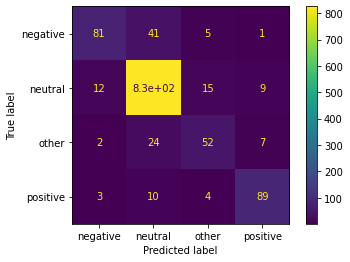

In [17]:
# Evaluate noncontextual data

runs_no_context = []
train_evaluate(runs_no_context, model_name_nc, t, tf.constant(train_labels), e, tf.constant(eval_labels), num_labels, init_lr, epochs, batch_size_train, 7)
print(f"Model: {model_name_nc}, initial learning rate = {init_lr}, input size = {input_size_nc}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(runs_no_context, eval_labels)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7494 - sparse_categorical_accuracy: 0.7549

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 647s 921ms/step - loss: 0.7491 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.3345 - val_sparse_categorical_accuracy: 0.8823
Epoch 2/3
686/686 [==============================] - 635s 926ms/step - loss: 0.2299 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.3277 - val_sparse_categorical_accuracy: 0.8798
Epoch 3/3
686/686 [==============================] - 636s 927ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.3653 - val_sparse_categorical_accuracy: 0.8789


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 256, batch size = 16, epochs = 3
Accuracy: 0.8823
Weighted F-score: 0.8807
Average accuracy: 0.8823, stdev: 0.0000
Average weighted F-score: 0.8807, stdev: 0.0000
              precision    recall  f1-score   support

    negative     0.7570    0.6328    0.6894       128
     neutral     0.9317    0.9339    0.9328       862
       other     0.7250    0.6824    0.7030        85
    positive     0.7538    0.9245    0.8305       106

    accuracy                         0.8823      1181
   macro avg     0.7919    0.7934    0.7889      1181
weighted avg     0.8819    0.8823    0.8807      1181



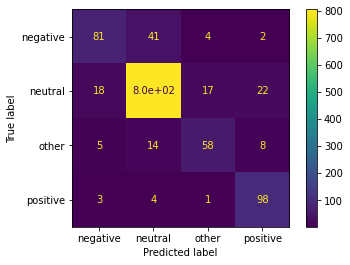

In [18]:
# Evaluate data with left context only

runs_left_context = []
train_evaluate(runs_left_context, model_name_c, t_left_sep, tf.constant(train_labels), e_left_sep, tf.constant(eval_labels), num_labels, init_lr, epochs, batch_size_train, 7)
print(f"Model: {model_name_c}, initial learning rate = {init_lr}, input size = {input_size_c}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(runs_left_context, eval_labels)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7263 - sparse_categorical_accuracy: 0.7432

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 656s 935ms/step - loss: 0.7261 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.3275 - val_sparse_categorical_accuracy: 0.8806
Epoch 2/3
686/686 [==============================] - 649s 946ms/step - loss: 0.2311 - sparse_categorical_accuracy: 0.9240 - val_loss: 0.3008 - val_sparse_categorical_accuracy: 0.8916
Epoch 3/3
686/686 [==============================] - 648s 944ms/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.3436 - val_sparse_categorical_accuracy: 0.8916


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 256, batch size = 16, epochs = 3
Accuracy: 0.8916
Weighted F-score: 0.8905
Average accuracy: 0.8916, stdev: 0.0000
Average weighted F-score: 0.8905, stdev: 0.0000
              precision    recall  f1-score   support

    negative     0.7652    0.6875    0.7243       128
     neutral     0.9378    0.9443    0.9410       862
       other     0.6951    0.6706    0.6826        85
    positive     0.8103    0.8868    0.8468       106

    accuracy                         0.8916      1181
   macro avg     0.8021    0.7973    0.7987      1181
weighted avg     0.8902    0.8916    0.8905      1181



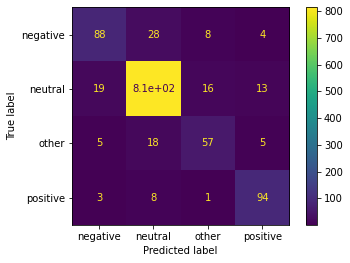

In [19]:
# Evaluate data with both left and right context

runs_full_context = []
train_evaluate(runs_full_context, model_name_c, t_full_sep, tf.constant(train_labels), e_full_sep, tf.constant(eval_labels), num_labels, init_lr, epochs, batch_size_train, 7)
print(f"Model: {model_name_c}, initial learning rate = {init_lr}, input size = {input_size_c}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(runs_full_context, eval_labels)